In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import requests
import json
import folium
import pgeocode
import datetime
from math import sqrt

In [2]:
def read_covid_data():
    global latitude, longtitude, newly_confirmed_10, covid_data_frame
    longtitude = []
    latitude = []
    location_code = []

    base_url = "https://api.covid19api.com/summary"
    base_page = requests.get(base_url)

    covid_data = BeautifulSoup(base_page.content, 'html.parser')
    covid_json_data = json.loads(str(covid_data))

    covid_data_frame = pd.DataFrame.from_dict(covid_json_data['Countries'])
    covid_data_frame.set_index(keys = ['Country'], inplace = True, drop = False)
    newly_confirmed_10 = covid_data_frame.nlargest(10, "NewConfirmed")
    
    for country in newly_confirmed_10.CountryCode:
        geolocator = geolocator = Nominatim(user_agent = "Covid_world_wide_data")
        location = geolocator.geocode(country)
        latitude.append(location.latitude)
        longtitude.append(location.longitude)

    print(covid_data_frame.columns)
        
read_covid_data()

Index(['Country', 'CountryCode', 'Slug', 'NewConfirmed', 'TotalConfirmed',
       'NewDeaths', 'TotalDeaths', 'NewRecovered', 'TotalRecovered', 'Date',
       'Premium'],
      dtype='object')


                                           Country CountryCode           Slug  \
Country                                                                         
United States of America  United States of America          US  united-states   
India                                        India          IN          india   
Brazil                                      Brazil          BR         brazil   
Russian Federation              Russian Federation          RU         russia   
France                                      France          FR         france   
Argentina                                Argentina          AR      argentina   
Spain                                        Spain          ES          spain   
Colombia                                  Colombia          CO       colombia   
Mexico                                      Mexico          MX         mexico   
Peru                                          Peru          PE           peru   

                          N

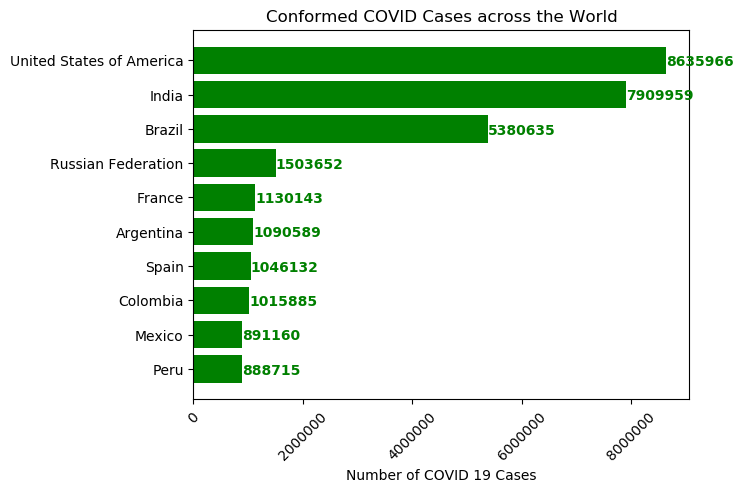

In [3]:
def total_confirmed(total_confirmed_covid_cases):
    x_axis = list(total_confirmed_covid_cases['Country'])
    y_axis = list(total_confirmed_covid_cases['TotalConfirmed'])
    plt.rcdefaults()
    fix, ax = plt.subplots()
    print(total_confirmed_covid_cases)
    ax.barh(x_axis,y_axis, align='center', color = 'green', data = y_axis)
    plt.xticks(rotation=45)
    ax.invert_yaxis()
    ax.set_xlabel('Number of COVID 19 Cases')
    ax.set_title('Conformed COVID Cases across the World')
    for i, v in enumerate(y_axis):
        ax.text(v + 3, i + .15, str(v), color='green', fontweight='bold')
    plt.show()
total_confirmed(covid_data_frame.nlargest(10,'TotalConfirmed'))

In [4]:
def newly_confirmed():
    global m
    newly_confirmed_covid = pd.DataFrame({'latitude' : latitude,
                                        'longtitude' : longtitude,
                                         'country' : (newly_confirmed_10.Country).to_list(),
                                         'Newly_confirmed' : list(newly_confirmed_10.NewConfirmed)})
    m = folium.Map(location = [90, -90],
                    zoom_start = 2)
    
    for i in range(0,10):
       folium.Circle(
          location=[float(newly_confirmed_covid.iloc[i]['latitude']), float(newly_confirmed_covid.iloc[i]['longtitude'])],
          popup=str(newly_confirmed_covid.iloc[i]['country'])+" newly confirmed "+ str(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          radius=int(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
    print(newly_confirmed_covid)
    
newly_confirmed()

    latitude  longtitude                   country  Newly_confirmed
0  39.783730 -100.445882  United States of America            60789
1  46.603354    1.888334                    France            45484
2  22.351115   78.667743                     India            45148
3  42.638426   12.674297                     Italy            21273
4  54.702354   -3.276575            United Kingdom            19797
5  64.686314   97.745306        Russian Federation            16392
6  50.640281    4.666715                   Belgium            15622
7  52.215933   19.134422                    Poland            11742
8  52.500170    5.748082               Netherlands            10202
9 -34.996496  -64.967282                 Argentina             9253


In [5]:
m

    Country CountryCode Province City CityCode Lat Lon    Cases     Status  \
0     India                                      0   0        1  confirmed   
1     India                                      0   0        1  confirmed   
2     India                                      0   0        1  confirmed   
3     India                                      0   0        2  confirmed   
4     India                                      0   0        3  confirmed   
..      ...         ...      ...  ...      ...  ..  ..      ...        ...   
265   India                                      0   0  7706946  confirmed   
266   India                                      0   0  7761312  confirmed   
267   India                                      0   0  7814682  confirmed   
268   India                                      0   0  7864811  confirmed   
269   India                                      0   0  7909959  confirmed   

                     Date  
0    2020-01-30T00:00:00Z  
1    20

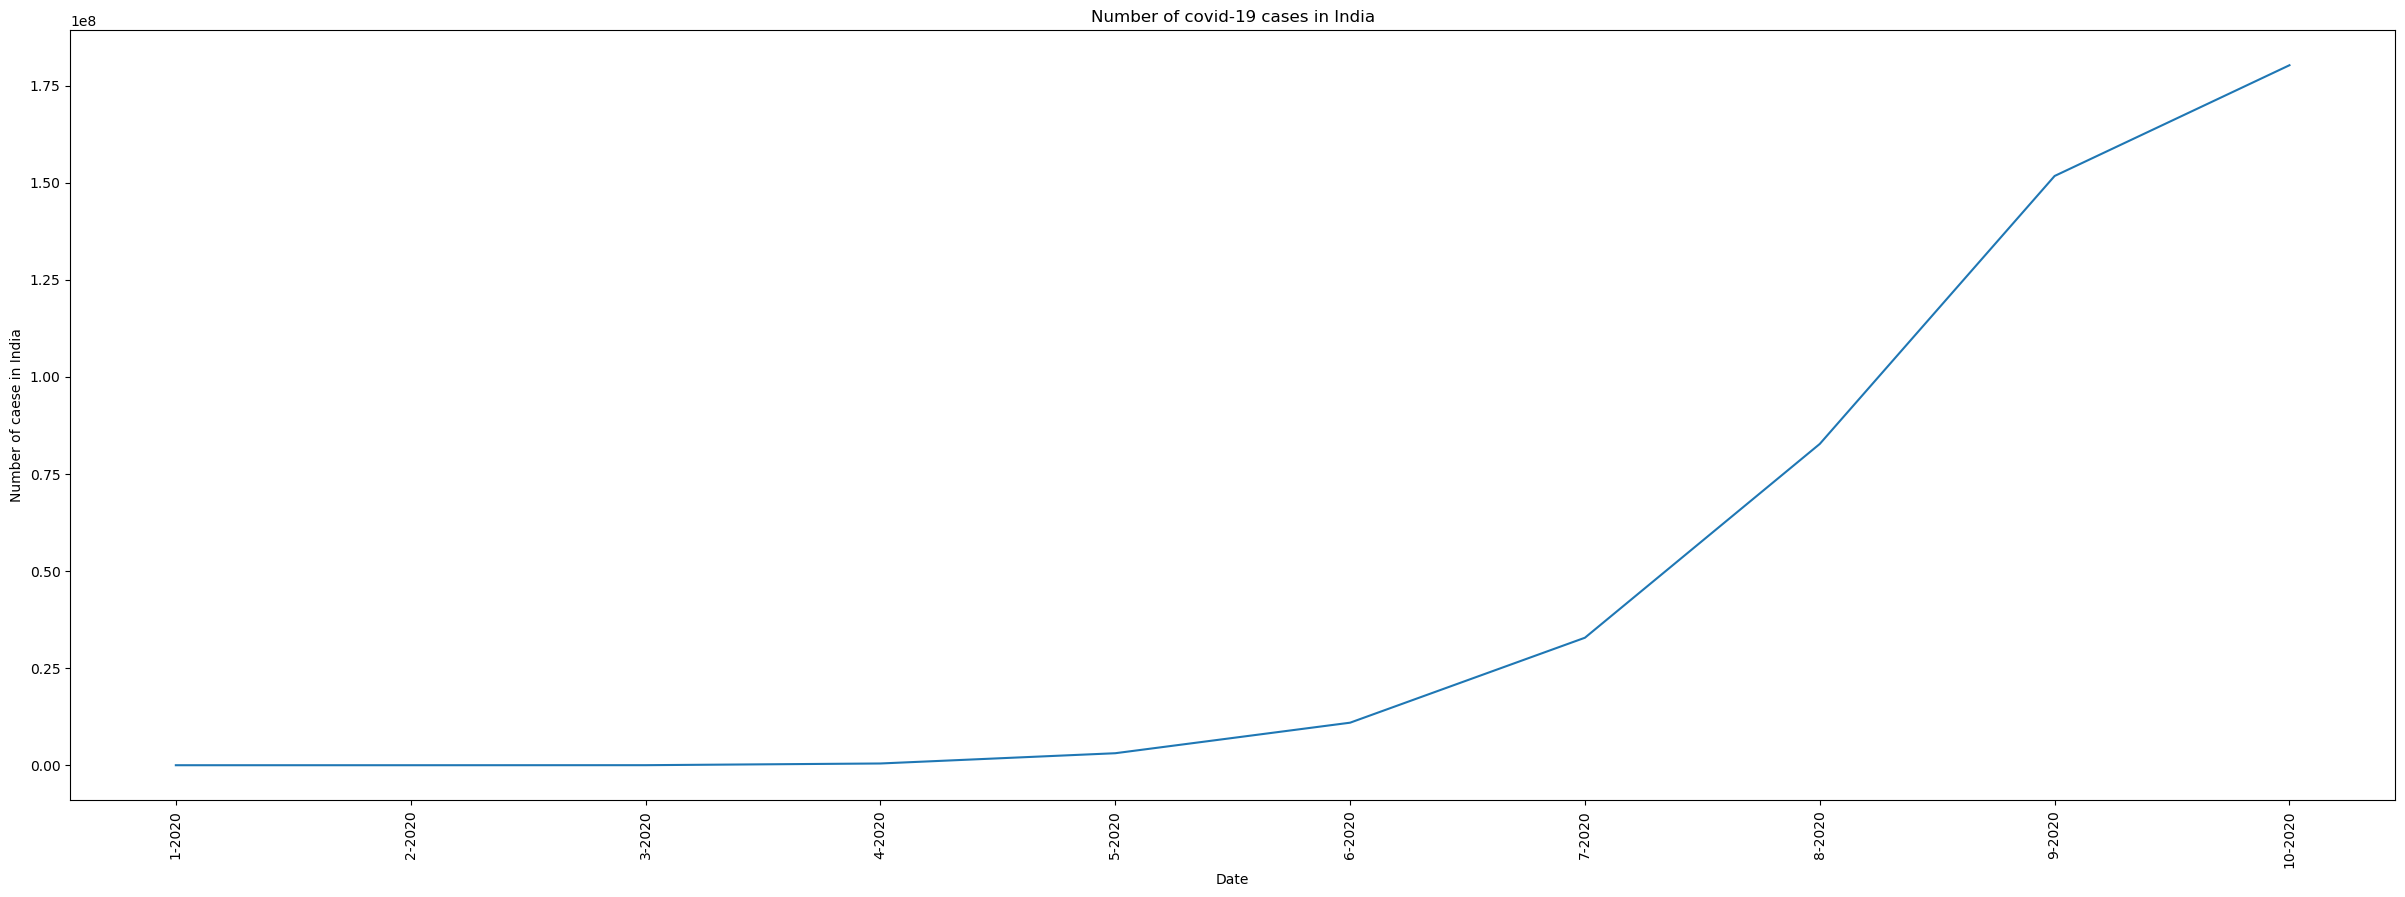

In [6]:
def india_covid_cases():
    global india_covid_dataframe
    base_url = "https://api.covid19api.com/total/dayone/country/india/status/confirmed"
    month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    base_india_covid_data = requests.get(base_url)
    base_india_covid_data = BeautifulSoup(base_india_covid_data.content,'html.parser')
    india_covid_data_json = json.loads(str(base_india_covid_data))
    india_covid_dataframe = pd.DataFrame.from_dict(india_covid_data_json)
    
    print(india_covid_dataframe)
    
    india_covid_dataframe.Date = pd.to_datetime(india_covid_dataframe.Date, dayfirst = True)
    
    india_covid_dataframe['Year'] = pd.DatetimeIndex(india_covid_dataframe['Date']).year
    india_covid_dataframe['Month'] = pd.DatetimeIndex(india_covid_dataframe['Date']).month
    month_wise_covid_data = india_covid_dataframe.groupby(by = ['Month', 'Year']).sum()
    month_wise_covid_data["Country"] = india_covid_dataframe.Country[0]
    
    Month_Year = []
    for month, year in month_wise_covid_data.index:
        Month_Year.append(str(month)+"-"+str(year))
    
    month_wise_covid_data['Month_Year'] = Month_Year
    print(month_wise_covid_data)
    plt.figure(figsize = [30,10])
    plt.subplot(1,1,1)
    plt.plot(month_wise_covid_data['Month_Year'], month_wise_covid_data['Cases'])
    plt.ylabel("Number of caese in India")
    plt.xlabel("Date")
    plt.xticks(rotation = 'vertical')
    plt.title("Number of covid-19 cases in India")
    
india_covid_cases()

[5201918.2085748  5228316.81718569 5254715.42579659 5281114.03440748
 5307512.64301837 5333911.25162926]
1207083.3409208984
0.7643111210066263


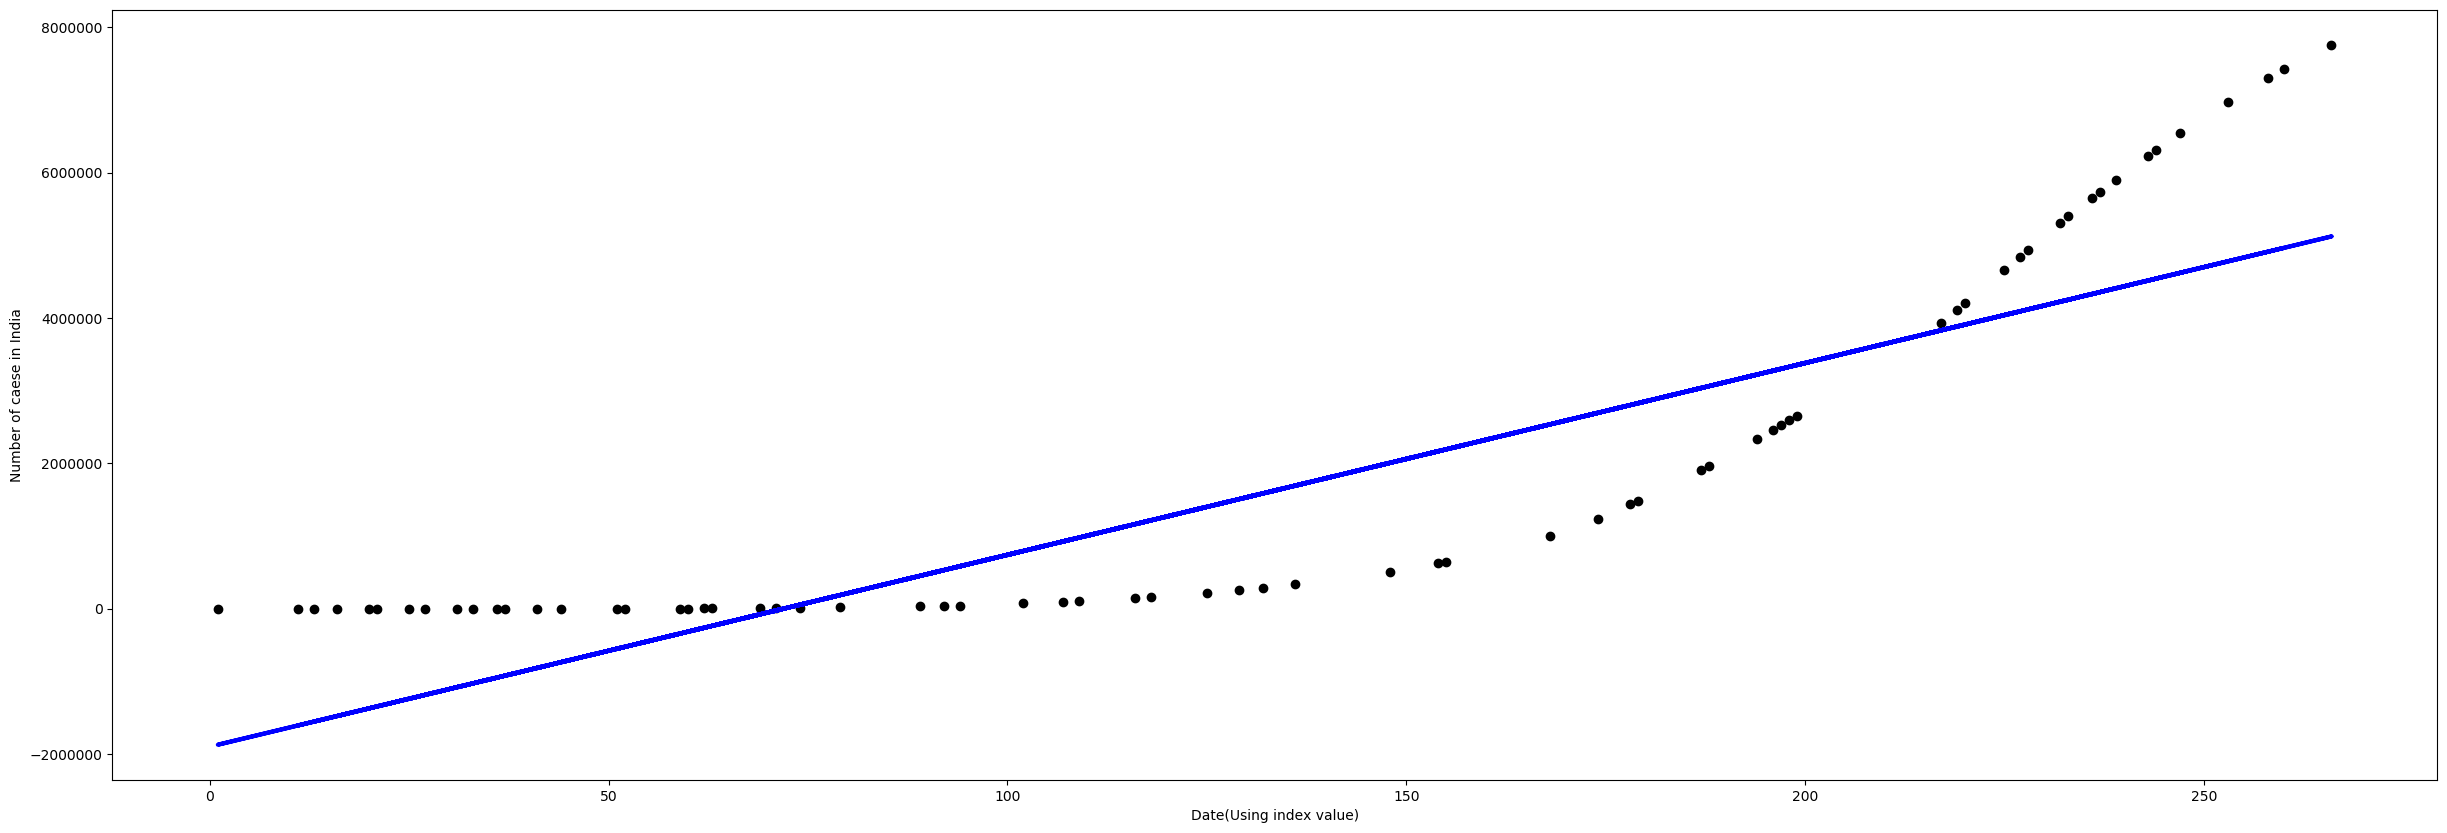

In [27]:
def covid_prdiction():
    x = india_covid_dataframe.index.to_numpy().reshape(-1, 1)
    y = (india_covid_dataframe['Cases']).to_numpy()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)    
    
    data = np.array([269, 270, 271, 272, 273, 274]).reshape((-1,1))
    print(regr.predict(data))
    
    print(sqrt(mean_squared_error(y_test, y_pred)))
    plt.figure(figsize = (30, 10))
    
    print("Accuracy Score"regr.score(x_test, y_test))

    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.ylabel("Number of caese in India")
    plt.xlabel("Date(Using index value)")
    plt.show()
    
covid_prdiction()